# Машинное обучение в бизнесе
# Урок 4. Uplift-моделирование

**Подготовка к выполнению задания**

In [ ]:
!pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 406 kB 5.0 MB/s 
     |████████████████████████████████| 564 kB 35.6 MB/s 
     |████████████████████████████████| 1.8 MB 36.5 MB/s 
     |████████████████████████████████| 718 kB 17.6 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1054290 sha256=2b3b5c55b08725591447d802499ecdfe2d59684bdd45b8ca00bba5d0d4fddedb
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 85 kB/s 


In [ ]:
import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_by_percentile
from sklift.viz import plot_uplift_by_percentile

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from catboost import CatBoostClassifier

# %matplotlib inline

## Задание 1
Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention.

In [ ]:
df = pd.read_csv('data.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [ ]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

## Задание 2
Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

Переименование

In [ ]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

Привод в бинарный вид и удаление признака treatment_No Offer - он не дает никакой дополнительной информации, т.к. нули в 2-х других признаках автоматически означают No Offer.

In [ ]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df['treatment'] = df['treatment'].astype(np.uint8)

In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


## Задание 3
Разбиение набора данных не тренировочную и тестовую выборки.

Делим датасет.

In [ ]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df.drop(columns=['target']), 
                                                            df['target'],
                                                            df['treatment'],
                                                            random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, treat_train.shape

((48000, 8), (16000, 8), (48000,), (16000,), (48000,))

## Задание 4
Провести uplift-моделирование 3 способами: 

1) одна модель с признаком коммуникации (S learner), 

2) модель с трансформацией таргета (трансформация классов п. 2. 1)

3) и вариант с двумя независимыми моделями.

Датафрейм для сравнения метрик.

In [ ]:
metrics_df = pd.DataFrame(columns=['uplift@10%', 'uplift@20%'])

Категориальные признаки.

In [ ]:
cat_features = ['zip_code', 'channel']

**Solo Learner**

In [ ]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)
print(uplift_sm)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

[0.08557733 0.07419337 0.08570074 ... 0.09613985 0.0500112  0.10886715]


Сохранение метрик модели.

In [ ]:
metrics_df = metrics_df.append({'uplift@10%': sm_score_10, 'uplift@20%': sm_score_20}, ignore_index=True)

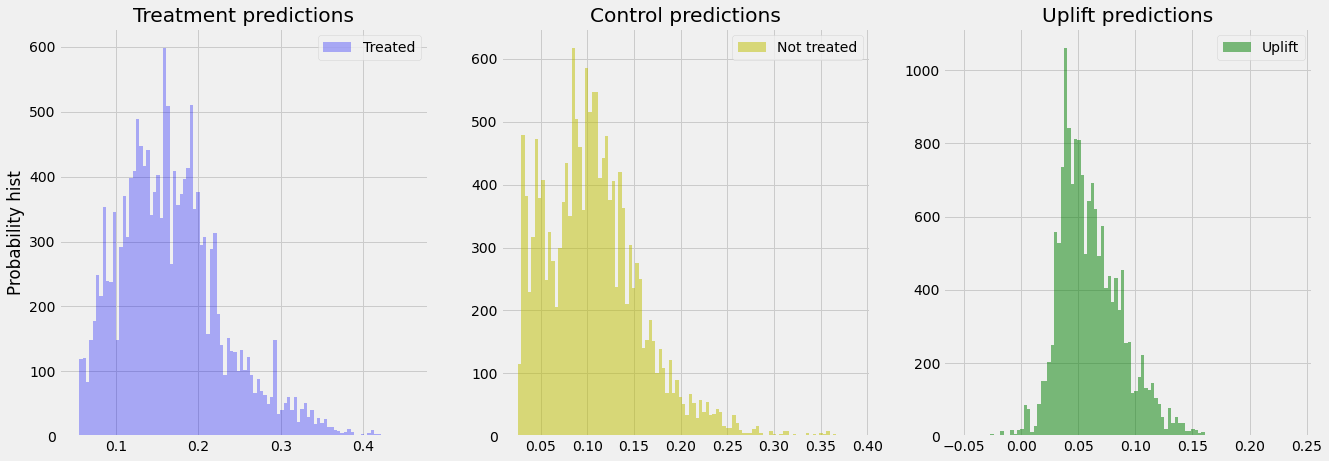

In [ ]:
sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

**Transform Learner**

In [ ]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)
print(uplift_ct)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

[-0.65130053 -0.65668588 -0.52379824 ...  0.73403501 -0.6053989
 -0.36820204]


Сохранение метрик модели.

In [ ]:
metrics_df = metrics_df.append({'uplift@10%': ct_score_10, 'uplift@20%': ct_score_20}, ignore_index=True)

**Two Model Learner**

In [ ]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)
print(uplift_tm)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

[0.10131404 0.06242448 0.08409682 ... 0.08187262 0.05867446 0.01930044]


Сохранение метрик модели.

In [ ]:
metrics_df = metrics_df.append({'uplift@10%': tm_score_10, 'uplift@20%': tm_score_20}, ignore_index=True)

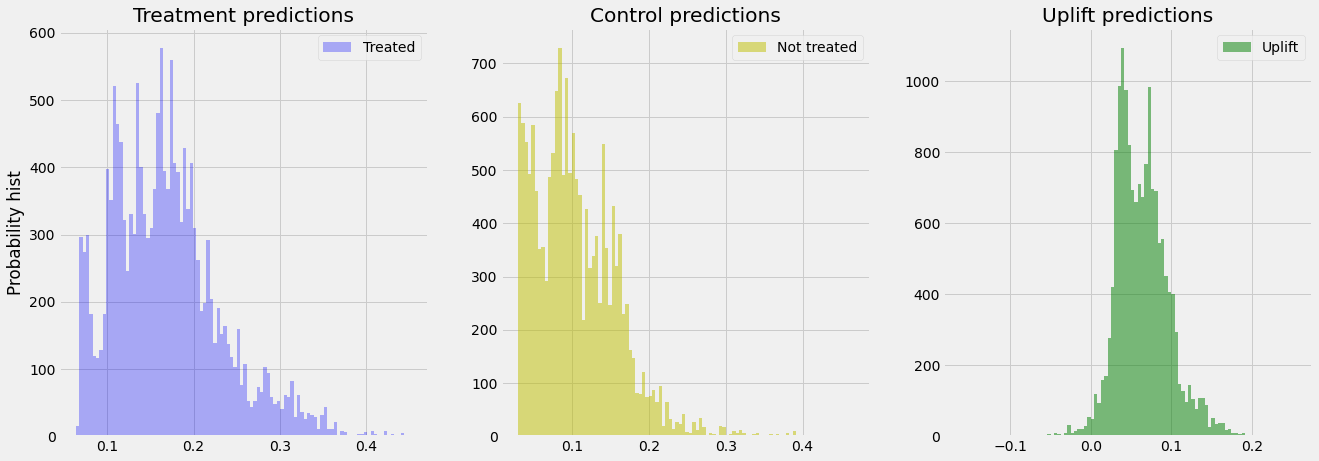

In [ ]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Задание 5
В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.

In [ ]:
metrics_df

,uplift@10%,uplift@20%
0,0.066734,0.058553
1,0.208646,0.184652
2,0.066734,0.073705


Похоже, что лучшие показатели у модели с трансформацией классов.

## Задание 6*
Для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 

1) сделать прогноз и получить uplift для тестовой выборки 

2) отсортировать тестовую выборку по uplift по убыванию 

3) разбить на децили (pandas qcut вам в помощь) 

4) для каждого дециля посчитать среднюю conversion.

In [ ]:
# Прогноз ранее уже был получен. Проверка, что он сохранен в памяти.
print(uplift_sm)

[0.08557733 0.07419337 0.08570074 ... 0.09613985 0.0500112  0.10886715]


In [ ]:
df = pd.DataFrame({'y': y_test, 'uplift': uplift_sm}).sort_values('uplift', ascending=False)
df['quantile_uplift'] = pd.qcut(df['uplift'], q=10)

print(df)

       y    uplift                  quantile_uplift
36852  1  0.239940                   (0.0974, 0.24]
59418  1  0.235900                   (0.0974, 0.24]
61866  0  0.212685                   (0.0974, 0.24]
25944  1  0.201470                   (0.0974, 0.24]
36314  0  0.185545                   (0.0974, 0.24]
...   ..       ...                              ...
63489  0 -0.050073  (-0.054400000000000004, 0.0311]
25383  0 -0.050073  (-0.054400000000000004, 0.0311]
39890  0 -0.050073  (-0.054400000000000004, 0.0311]
23662  0 -0.053366  (-0.054400000000000004, 0.0311]
22463  0 -0.053372  (-0.054400000000000004, 0.0311]

[16000 rows x 3 columns]


In [ ]:
df_gb_1 = df.groupby('quantile_uplift').sum()
df_gb_1 = df_gb_1.rename(columns={"y": "y_sum", "uplift": "uplift_sum"})
df_gb_2 = df.groupby('quantile_uplift').count()
df_gb_2 = df_gb_2.rename(columns={"y": "y_count", "uplift": "uplift_count"})

In [ ]:
df_conv = pd.concat([df_gb_1, df_gb_2], axis=1)
df_conv['conversion'] = df_conv['y_sum'] / df_conv['y_count']
print(df_conv.sort_values('quantile_uplift', ascending=False))

                                 y_sum  uplift_sum  y_count  uplift_count  \
quantile_uplift                                                             
(0.0974, 0.24]                     342  186.466175     1598          1598   
(0.0832, 0.0974]                   251  142.758077     1602          1602   
(0.0714, 0.0832]                   222  122.624151     1592          1592   
(0.0634, 0.0714]                   246  108.263338     1605          1605   
(0.056, 0.0634]                    228   95.745064     1598          1598   
(0.0495, 0.056]                    226   84.152701     1602          1602   
(0.0431, 0.0495]                   232   74.025800     1593          1593   
(0.0382, 0.0431]                   197   65.009564     1605          1605   
(0.0311, 0.0382]                   175   56.289040     1598          1598   
(-0.054400000000000004, 0.0311]    203   33.711510     1607          1607   

                                 conversion  
quantile_uplift              

Самая лучшая конверсия в квантиле (0.0974, 0.24]. С самыми большими значениями uplift.